## Infinite Impulse Response (IIR) Filters (Remixed)

In [23]:
#https://github.com/scipy/scipy/blob/v1.8.0/scipy/signal/_signaltools.py#L1866-L2057
def _validate_x(x):
    x = np.asarray(x)
    if x.ndim == 0:
        raise ValueError('x must be at least 1-D')
    return x

def nlfilter(b, a, x, axis=-1, zi=None):
    """ Apply a non-linear filter to the signal x. """
    
    # return NotImplementedError("Not implemented yet")

In [24]:
def sample_poles(filter_order):
    """
    Systems represented by stable right-sided sequences have all poles located within the unit circle, which suggests all eigenvalues of the system have magnitude less than one and thus state variables decay over time.
    """
    centerX = centerY = 0
    R = 1
    z = [0] * filter_order
    p = []
    for _ in range(filter_order // 2):
        r = R * np.sqrt(np.random.rand())
        theta = np.random.rand() * 2 * np.pi
        x = centerX + r * np.cos(theta)
        y = centerY + r * np.sin(theta)
        t = x + y * 1j

        p.append(t)
        p.append(t.conjugate())

    if filter_order%2 == 1:
        p.append(np.random.rand())
    return z, p

def create_gaussian_signal(seq_len, b, a):
    """
    Filter gaussian noise throught the IIR filter designed via Pole-sampling
    """
    xn = np.random.normal(0, 1, size=seq_len)
    x = np.tanh(signal.lfilter(b, a, xn))
    return xn, x

# Create input and output of shape (batch_size x seq_len x input_dims) 
def create_dataset(batch_size, seq_len, b, a):
    X = []
    Y = []
    for _ in range(batch_size):
        xn, x = create_gaussian_signal(seq_len, b, a)
        X.append(xn)
        Y.append(x)
            
    X = np.array(X)
    X = np.swapaxes(X, 0, 1)
    X = np.expand_dims(X, axis=2)

    Y = np.array(Y)
    Y = np.swapaxes(Y, 0, 1)
    Y = np.expand_dims(Y, axis=2)

    return X, Y

In [25]:
import numpy as np
import scipy.signal as signal

# Set Parameters
filter_order = N = 3
hidden_size = 3

seq_len = 150
wash_out = 50
batch_size = 100
split_ratio = 0.8

# Generate Data
z, p = sample_poles(filter_order)
b, a = signal.zpk2tf(z, p, 1)

X, Y = create_dataset(batch_size, seq_len, b, a)

split_index = int(split_ratio*batch_size)
train_X, train_Y = X[:,:split_index,:], Y[:,:split_index,:]
test_X, test_Y = X[:,split_index:,:], Y[:,split_index:,:]

## Visualize the Response
### Impulse Response

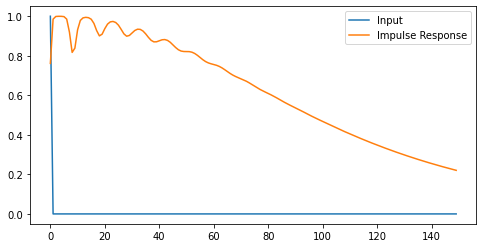

In [26]:
import matplotlib.pyplot as plt

input = signal.unit_impulse(seq_len)
output = np.tanh(signal.lfilter(b, a, input))

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.plot(input, label="Input")
ax.plot(output, label="Impulse Response")
plt.legend()
plt.show()

### Gaussian Noise

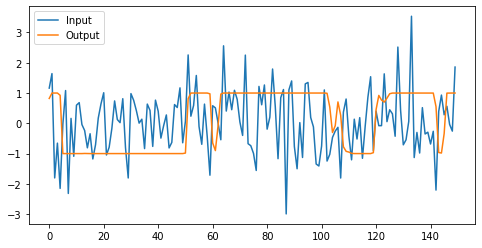

In [27]:
input = np.random.normal(0, 1, size=seq_len)
output = np.tanh(signal.lfilter(b, a, input))

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.plot(input, label="Input")
ax.plot(output, label="Output")
plt.legend()
plt.show()

## Define Recurrent Neural Network Model


In [28]:
import torch
from torch import nn

class RNNLayer(nn.Module):
    """Linear RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
                if None, hidden is initialized through self.init_hidden()
        
    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=False)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.
        
        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)
        
        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = torch.tanh(self.i2h(input) + self.h2h(hidden))
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        
        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)
            hidden.requires_grad = True

        # Loop through time
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            hidden.retain_grad()
            output.append(hidden)

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)
        return output, hidden


class RNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
    
    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        self.rnn = RNNLayer(input_size, hidden_size, **kwargs)
        self.fc = nn.Linear(hidden_size, output_size, bias=False)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output

In [29]:
import cmath
import matplotlib.pyplot as plt

def extract_eigen_values(M):
    eW = np.linalg.eigvals(M)
    rea = [n.real for n in eW]
    imag = [n.imag for n in eW]
    return rea, imag

def polar_plot(real_poles, imag_poles, realW_bptt, imagW_bptt, realW_filter=[], imagW_filter=[]):
    fig = plt.figure(figsize=(12,12))

    theta, r = [], []
    for i,j in zip(real_poles, imag_poles):
        r_c, theta_c = cmath.polar(complex(i, j))
        r.append(r_c)
        theta.append(theta_c)

    r_bptt, theta_bptt = [], []
    for i,j in zip(realW_bptt, imagW_bptt):
        r_c, theta_c = cmath.polar(complex(i, j))
        r_bptt.append(r_c)
        theta_bptt.append(theta_c)
    
    if realW_filter is not None:
        r_filter, theta_filter = [], []
        for i,j in zip(realW_filter, imagW_filter):
            r_c, theta_c = cmath.polar(complex(i, j))
            r_filter.append(r_c)
            theta_filter.append(theta_c)

    ax = fig.add_subplot(121, projection='polar')
    ax.scatter(theta, r, color='blue', marker='x', label='Poles')
    ax.scatter(theta_bptt, r_bptt, color='red', marker='.', label='Eigenvalues')
    if realW_filter is not None:
        ax.scatter(theta_filter, r_filter, color='green', marker='.', label='Filtered Eigenvalues')
    ax.set_rmax(1)
    ax.set_rticks([0.25, 0.5, 0.75, 1])    # Less radial ticks
    ax.set_rlabel_position(-22.5)          # Move radial labels away from plotted line
    ax.grid(True)
    ax.legend(bbox_to_anchor=(1, -0.05), loc="center right", frameon=False)
    plt.show()  

In [30]:
# Instantiate Model
net = RNNNet(1, N, 1)

# Shifted diagonal matrix and IIR filter coefficients
a_copy = -a
a_copy[0] = 1
h2h = torch.diag(torch.ones(N-1), diagonal=-1)
h2h[0,:] = torch.from_numpy(a_copy[1:])
net.rnn.h2h.weight = nn.Parameter(h2h)

# Vector with a "1" for input x
i2h = torch.zeros((N,1))
i2h[0,0] = torch.tensor(1.0)
net.rnn.i2h.weight = nn.Parameter(i2h)

# Weight for linear output layer to select h[0]
fc = torch.zeros((1,N))
fc[0][0] = torch.tensor(1.0)
net.fc.weight = nn.Parameter(fc)

# Predict
test_inp = torch.from_numpy(test_X).type(torch.float)
test_out = torch.from_numpy(test_Y).type(torch.float)
pred, rnn_output = net(test_inp)

# Compute Loss
criterion = nn.MSELoss()
loss_optimal = criterion(pred[wash_out:,:,:], test_out[wash_out:,:,:]).detach().numpy()
print(loss_optimal)

1.3107812


## Train the RNN

In [31]:
net_trained = RNNNet(1, hidden_size, 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net_trained.parameters(), lr=0.01)

loss_train = []
epochs = 3000
for epoch in range(epochs):
    # Zero the gradient buffer
    optimizer.zero_grad()
    
    # Forward pass
    train_inp = torch.from_numpy(train_X).type(torch.float)
    train_out = torch.from_numpy(train_Y).type(torch.float)

    pred, _ = net_trained(train_inp)

    # Measure the loss
    loss = criterion(pred[:,wash_out:,:], train_out[:,wash_out:,:])
    loss_train.append(loss.data.item())

    # Print the loss
    if epoch%50==0:
        print(epoch, loss.data.item())

    # Backward pass
    loss.backward()
    optimizer.step()

0 0.9222409725189209
50 0.39177820086479187
100 0.31548580527305603
150 0.29179179668426514
200 0.2884311079978943
250 0.28735432028770447
300 0.28641220927238464
350 0.28519731760025024
400 0.2839428782463074
450 0.28276005387306213
500 0.2816062867641449
550 0.2804875671863556
600 0.2794148027896881
650 0.27837565541267395
700 0.27731969952583313
750 0.2761348485946655
800 0.31645578145980835
850 0.2761247158050537
900 0.274912029504776
950 0.27395254373550415
1000 0.27269676327705383
1050 0.2708592712879181
1100 0.2679792642593384
1150 0.2626057267189026
1200 0.2456030547618866
1250 0.273582398891449
1300 0.1961328089237213
1350 0.21503067016601562
1400 0.13571272790431976
1450 0.13331906497478485
1500 0.13286352157592773
1550 0.13237731158733368
1600 0.1318453848361969
1650 0.13125944137573242
1700 0.1306116133928299
1750 0.1315663605928421
1800 0.1291370689868927
1850 0.12908108532428741
1900 0.12891821563243866
1950 0.12890423834323883
2000 0.12732984125614166
2050 0.125616446137

In [32]:
def plot_loss_history(loss_train, loss_test, loss_optimal):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    ax.loglog(loss_train, color='red', label ="BPTT Train")
    ax.loglog(loss_test*np.ones(epochs), color='orange', label ="BPTT Test")
    if loss_optimal is not None:
        ax.loglog(loss_optimal*np.ones(epochs), color='blue', label ="Optimal")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    plt.legend()
    plt.show()

0.1293799


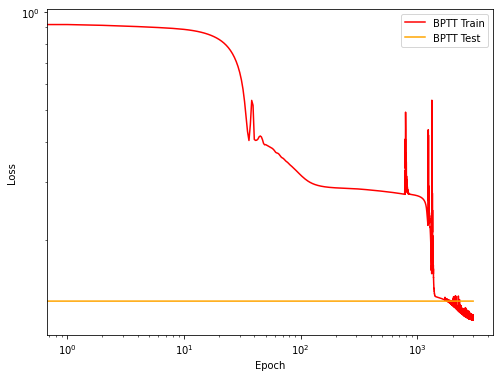

In [33]:
# Predict
test_inp = torch.from_numpy(test_X).type(torch.float)
test_out = torch.from_numpy(test_Y).type(torch.float)

test_inp.requires_grad = True
test_out.requires_grad = True

pred, rnn_output = net_trained(test_inp)

# Compute Loss
loss_test = criterion(pred[wash_out:,:,:], test_out[wash_out:,:,:]).detach().numpy()
print(loss_test)

plot_loss_history(loss_train, loss_test, None)

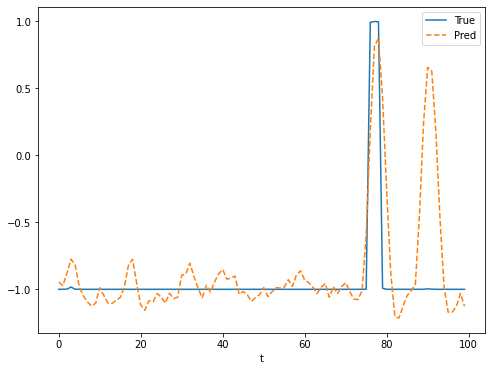

In [34]:
def plot_time_series(true, pred):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    ax.plot(true, label="True", linestyle='solid')
    ax.plot(pred, label="Pred", linestyle='dashed')
    ax.set_xlabel("t")
    plt.legend(loc=1)
    plt.show()

index_to_plot = 0
plot_time_series(test_out[wash_out:,index_to_plot,0].detach().numpy(), pred[wash_out:,index_to_plot,0].detach().numpy())

## Compute the Jacobian

In [35]:
def filter(x):
    return np.tanh(signal.lfilter(b, a, x))
    
# Long-term Jacobian for the all-pole filter
jac_filter = torch.zeros(N, N)

# for i in range(len(test_inp_select)):
#     jac_filter_0 = torch.autograd.functional.jacobian(filter, test_inp_select[i:i+1])

In [36]:
_, rnn_state = net_trained(test_inp[0:wash_out,0:1,:])
_, rnn_state = net_trained(test_inp[wash_out:,0:1,:])
rnn_state.shape

torch.Size([100, 1, 3])

In [37]:
def jacobian(h):
    """Compute the Jacobian of an RNN state vector h(t+1) with respect to h(t) for each t.

    :param h: shape [T, N]; output from an RNN
    :return: tensor of Jacobian matrices of shape [T-1, N, N]
    """
    T, _, N = h.shape
    J = []
    for t in range(T-1):
        J_t = []
        for n in range(N):
            output = torch.zeros(hidden_size)
            output[i] = 1.
            J_t.append(torch.autograd.grad(h[t+1,:,n], h[t])[0])
            # J_t.append(torch.autograd.grad(h[t+1], h[t,:,n], allow_unused=True, retain_graph=True, grad_outputs=output)[0])
        J_t = torch.stack(J_t)  # [N, N]
        J.append(J_t)
    J = torch.stack(J)  # [T-1, N, N]
    return J

jacobian(rnn_state)

NameError: name 'i' is not defined

In [ ]:
# for i in range(hidden_size):
#     jac_bptt[:,i] = torch.autograd.grad(net.rnn.recurrence(input_step, rnn_output), input_step, grad_outputs=None, retain_graph=True)[0]
# jac_bptt = jac_bptt.detach().numpy().T

# for input_step in test_inp[wash_out:,0:1,:]:
#     jac_bptt[:,i] = torch.autograd.grad(net.rnn.recurrence(input_step, rnn_output), input_step, grad_outputs=None, retain_graph=True)[0]

# Long-term Jacobian for the RNN
jac_bptt_t = []
jac_bptt_product = torch.eye(hidden_size, hidden_size)

_, rnn_state = net_trained(test_inp[0:wash_out,0:1,:])
rnn_state = rnn_state[-1]

len = 10
for input in test_inp[wash_out:wash_out+len,0:1,:]:
    jac_bptt_step = torch.zeros(hidden_size, hidden_size)
    func = net.rnn.recurrence(input, rnn_state)
    for i in range(hidden_size):
        output = torch.zeros(hidden_size)
        output[i] = 1.
        jac_bptt_step[:,i] = torch.autograd.grad(func[0,:], rnn_state, grad_outputs=output, retain_graph=True)[0]
    rnn_state = func
    
    jac_bptt_step = jac_bptt_step.detach().numpy().T
    jac_bptt_t.append(jac_bptt_step)
    jac_bptt_product = np.matmul(jac_bptt_product, jac_bptt_step)


In [ ]:
jac_bptt_product

tensor([[ 1.6960e-06, -2.5577e-07,  8.8855e-09],
        [-4.8467e-06,  9.0234e-07, -3.8115e-08],
        [ 9.3367e-06, -2.2304e-06,  1.0995e-07]])

In [ ]:
from scipy.linalg import fractional_matrix_power

jac_bptt = fractional_matrix_power(jac_bptt_product, 1/test_inp[wash_out+len:,0:1,:].shape[0])

In [ ]:
jac_bptt

array([[ 8.53871617e-01, -4.80719218e-03, -3.18022020e-04],
       [-9.58156429e-02,  8.23677790e-01, -5.60900661e-03],
       [-4.71014204e-01, -3.59877009e-01,  7.69964897e-01]])

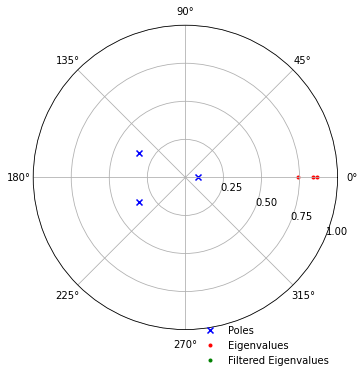

In [ ]:
# Compare the salient eigenvalues

real_poles, imag_poles = [x.real for x in p], [x.imag for x in p]
# realW_filter, imagW_filter = extract_eigen_values(jac_filter)
realW_bptt, imagW_bptt = extract_eigen_values(jac_bptt)

polar_plot(real_poles, imag_poles, realW_bptt, imagW_bptt)
# polar_plot(real_poles, imag_poles, realW_bptt, imagW_bptt, realW_filter, imagW_filter)

# Supplementary Material

## Comparison of target time-series FT and hidden activity FT

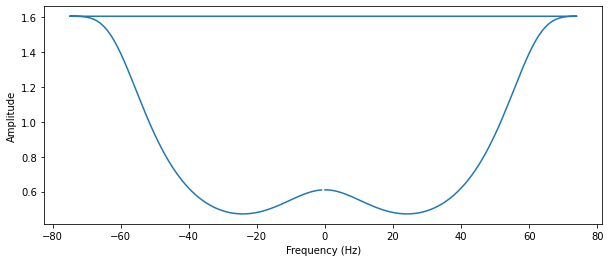

In [ ]:
from scipy import fftpack

fft = fftpack.fft(output)

amplitude = abs(fft)
power = amplitude**2
angle = np.angle(fft)

peak_amplitude_index = np.argmax(abs(fft))

sample_freq = fftpack.fftfreq(len(output), d=1/seq_len)
peak_amplitude_freq = sample_freq[peak_amplitude_index]

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.plot(sample_freq, abs(fft))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
print(peak_amplitude_freq)

-75.0


In [ ]:
print(realW_bptt)
print(imagW_bptt)

[-0.4604393, -0.4604393, 0.4540229]
[0.2696518, -0.2696518, 0.0]


In [ ]:
print(imagW_bptt[0]/(2*np.pi))

0.04291641694634346
